<h1>IBM Deep Learning Professional Certificate Capstone Project - Wan Chi Fung</h1>


<h2>Classifying European Money Denominations with CNN (Resnet18 and DenseNet 121)</h2>

In [1]:
# Download Training Dataset
!wget --quiet -O /resources/data/training_data_pytorch.tar.gz https://cocl.us/DL0320EN_TRAIN_TAR_PYTORCH
!tar -xzf  /resources/data/training_data_pytorch.tar.gz -C /resources/data --exclude '.*'

# Download Validation Dataset
!wget --quiet -O /resources/data/validation_data_pytorch.tar.gz https://cocl.us/DL0320EN_VALID_TAR_PYTORCH
!tar -xzf  /resources/data/validation_data_pytorch.tar.gz -C /resources/data --exclude '.*'

Import the PyTorch Modules needed.


In [2]:
# Import PyTorch Modules will be used
import torch 
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas
from torchvision import transforms  
import torch.nn as nn
torch.manual_seed(0)

Import Non-PyTorch Modules.

In [3]:
# Import Non-PyTorch Modules will be used

import time
from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np

Load and plot sample one <i>0.jpeg</i> from the training data. 

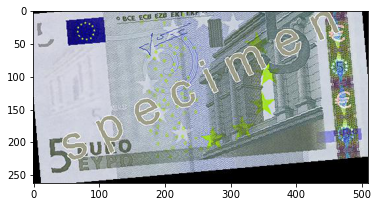

In [4]:
Input= "/resources/data/training_data_pytorch/0.jpeg"
img = Image.open(Input)
plt.imshow(img)

<h2 id="gen">Create Dataset Class and Object</h2>


The denomination, file name and the class variable for the training and validation data are stored in the following csv file.


In [5]:
# Url that contains CSV files

train_csv_file = 'https://cocl.us/DL0320EN_TRAIN_CSV'
validation_csv_file = 'https://cocl.us/DL0320EN_VALID_CSV'

The training images and validation images  are stored in the following directories.


In [6]:
# Absolute path for finding the directory contains image datasets

train_data_dir = '/resources/data/training_data_pytorch/'
validation_data_dir = '/resources/data/validation_data_pytorch/'

In [7]:
# Creating Dateaset Class

class Dataset(Dataset):
    
    # Constructor
    def __init__(self, csv_file, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data_name = pd.read_csv(csv_file)
        self.len = self.data_name.shape[0] 
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        img_name = self.data_dir + self.data_name.iloc[idx, 2]
        image = Image.open(img_name)
        y = self.data_name.iloc[idx, 3]
        if self.transform:
            image = self.transform(image)
        return image, y

Using the constructor <code>compose</code> to perform sequence of transformations in the order they are given


In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize((224, 224))
                               , transforms.ToTensor()
                               , transforms.Normalize(mean, std)])

Creating a training dataset and validation dataset object using the csv file stored in the variables. The parameter transform is set to the object <code>composed</code>. 

In [9]:
train_dataset = Dataset(transform=composed
                        ,csv_file=train_csv_file
                        ,data_dir=train_data_dir)

validation_dataset = Dataset(transform=composed
                          ,csv_file=validation_csv_file
                          ,data_dir=validation_data_dir)

<hr>


Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true.


In [10]:
model = models.resnet18(pretrained=True)

Seting the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [11]:
for param in model.parameters():
    param.requires_grad=False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


The output layer <code>model.fc</code> of the neural network is replaced with a <code>nn.Linear</code> object, to classify 7 different bills. The last hidden layer has 512 neurons.


In [12]:
model.fc = nn.Linear(512,7)

Print out the model.

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Create a cross entropy criterion function 


In [14]:
criterion = nn.CrossEntropyLoss()

Creating a training loader and validation loader object


In [15]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=15)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=10)

Applying optimizer to minimize the loss.


In [16]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad],lr=0.003)

Training the model for 20 epochs.


In [17]:
N_EPOCHS = 20
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)

for epoch in range(N_EPOCHS):
    loss_sublist=[]
    for x,y in train_loader:
        model.train()
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z,y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
        
    correct = 0
    for x_test,y_test in validation_loader:
        model.eval()
        z = model(x_test)
        _,yhat = torch.max(z.data,1)
        correct += (yhat == y_test).sum().item()
        accuracy = correct/n_test
    accuracy_list.append(accuracy)
 
    print('\n Epoch：{}, Testing loss: {}, acc: {}\n'.format(epoch,np.mean(loss_sublist), accuracy))



 Epoch：0, Testing loss: 4.143758726119995, acc: 0.32857142857142857


 Epoch：1, Testing loss: 1.8787112474441527, acc: 0.18571428571428572


 Epoch：2, Testing loss: 1.8709094524383545, acc: 0.17142857142857143


 Epoch：3, Testing loss: 1.9922539472579956, acc: 0.4714285714285714


 Epoch：4, Testing loss: 1.6563254833221435, acc: 0.6714285714285714


 Epoch：5, Testing loss: 1.3890539288520813, acc: 0.7285714285714285


 Epoch：6, Testing loss: 1.1800492525100708, acc: 0.6857142857142857


 Epoch：7, Testing loss: 1.1796428680419921, acc: 0.6571428571428571


 Epoch：8, Testing loss: 1.1743404626846314, acc: 0.8


 Epoch：9, Testing loss: 1.0875024914741516, acc: 0.8714285714285714


 Epoch：10, Testing loss: 0.9897138476371765, acc: 0.8857142857142857


 Epoch：11, Testing loss: 0.926990294456482, acc: 0.9


 Epoch：12, Testing loss: 0.907694935798645, acc: 0.9285714285714286


 Epoch：13, Testing loss: 0.8806324362754822, acc: 0.9428571428571428


 Epoch：14, Testing loss: 0.8347681999206543, 

Plot the training loss for each iteration


Text(0, 0.5, 'Average Loss per Epoch')

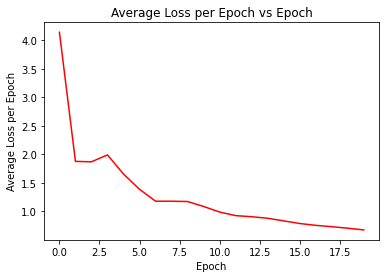

In [18]:
plt.plot(np.array(loss_list), 'r')
plt.title('Average Loss per Epoch vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss per Epoch') 

Plot the validation accuracy for each epoch


Text(0, 0.5, 'Accuracy')

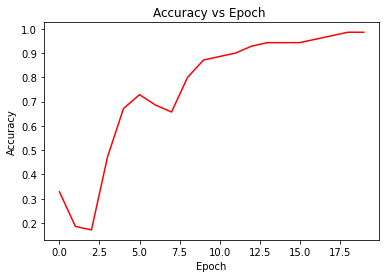

In [19]:
plt.plot(np.array(accuracy_list), 'r')
plt.title('Accuracy vs Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Creating a test dataset using validation data. And, 5 random images are plotted. The predicted label and a string is printed to indicate whether it has been correctly classified or mis-classified.


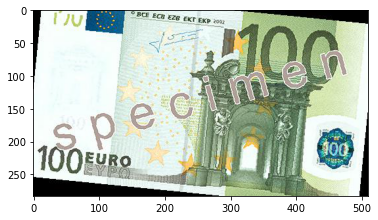

predicted: $100  (Correctly Classified)


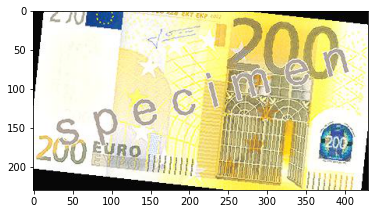

predicted $200  (Correctly Classified)


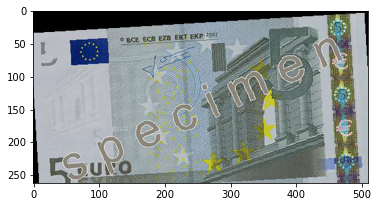

predicted: $5  (Correctly Classified)


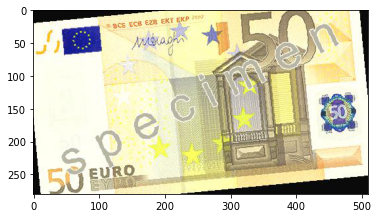

predicted: $50  (Correctly Classified)


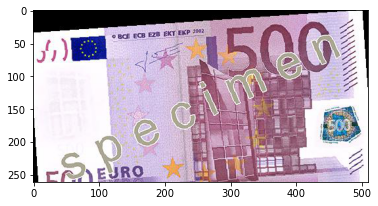

predicted $500  (Correctly Classified)


In [20]:
# Plot the images with labels

look_up = {0: 'predicted: $5'
           , 1: 'predicted: $10'
           , 2: 'predicted: $20'
           , 3: 'predicted: $50'
           , 4: 'predicted: $100'
           , 5: 'predicted $200'
           , 6: 'predicted $500'}
random.seed(0)
numbers = random.sample(range(70), 5)

   
validation_data_name = pd.read_csv(validation_csv_file)
def plot_random_image(n):
    validation_image_name = validation_data_dir + validation_data_name.iloc[n, 2]
    image = Image.open(validation_image_name)
    plt.imshow(image)
    plt.show()
    
for n in numbers:
    plot_random_image(n)
    result=validation_dataset.__getitem__(n)
    model.eval()
    z=model(torch.unsqueeze(result[0], 0))
    #z=model(result[0])
    _,yhat=torch.max(z.data,1)    
    #yhat=1
    #print (yhat,result[1])
    if yhat[0]==result[1]:
       print(look_up[yhat.item()]," (Correctly Classified)")
    else:
       print(look_up[yhat.item()]," (Mis-classified)")     

Repeating above steps to predict the result using <code>models.densenet121</code> model.


In [21]:
# Use densenet121 to train the model and print out the last validation accuracy.

model_des = models.densenet121(pretrained=True)

for param in model_des.parameters():
    param.requires_grad=False
    
model_des.classifier = nn.Linear(1024, 7) #change to 1024
print(model_des)

criterion_des = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=15)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=10)
optimizer = torch.optim.Adam([parameters for parameters in model_des.parameters() if parameters.requires_grad],lr=0.003)

N_EPOCHS = 10
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)

for epoch in range(N_EPOCHS):
    loss_sublist=[]
    for x,y in train_loader:
        model_des.train()
        optimizer.zero_grad()
        z = model_des(x)
        loss = criterion_des(z,y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
        
    correct = 0 
    for x_test,y_test in validation_loader:
        model_des.eval()
        z = model_des(x_test)
        _,yhat = torch.max(z.data,1)
        correct += (yhat == y_test).sum().item()
        accuracy = correct/n_test
    accuracy_list.append(accuracy)
 
    print('\n Epoch：{}, Testing loss: {}, acc: {}\n'.format(epoch,np.mean(loss_sublist), accuracy))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
# last validation accuracy
print("The last validation accuracy: = {}".format(accuracy))

The last validation accuracy: = 0.9571428571428572


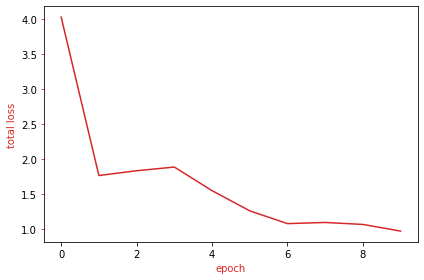

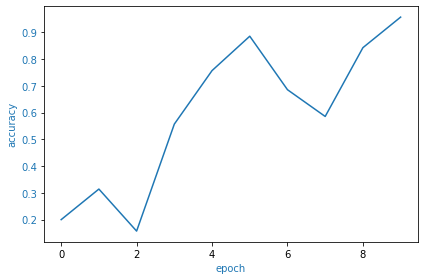

In [23]:
#Plot loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
fig.tight_layout()

fig, ax2 = plt.subplots()
color = 'tab:blue'
ax2.set_xlabel('epoch',color=color)
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
